# this notebook is for binning error bars to a fixed resolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from binning import bin_errs, calc_bin_widths

In [2]:
pandexo_errs = np.loadtxt('./pandexo_output/pandexo_errs.txt').T
pandexo_errs_20 = np.loadtxt('./pandexo_output/pandexo_errs_20.txt').T

In [3]:
x, y, e = pandexo_errs           # native resolution
x20, y20, e20 = pandexo_errs_20  # pandexo R = 20

### For reference, here are the error curves produced with Pandexo. I'm trying to take the unbinned pandexo errors (black) and bin them myself, and it should match pandexo's $R = 20$ binned errors (blue).

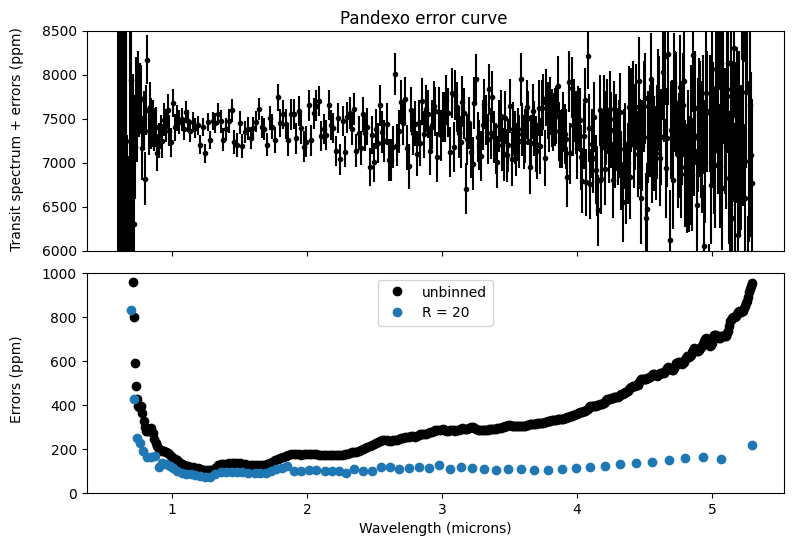

In [4]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)

axs[0].errorbar(x, y, e, fmt = '.', c = 'black')
axs[1].plot(x, e, 'o', label = 'unbinned', c = 'black')
axs[1].plot(x20, e20, 'o', label = 'R = 20')

axs[0].set_ylim(6000,8500)
axs[1].set_ylim(0, 1000)

# Labels
fig.suptitle('Pandexo error curve', y = 0.915)
fig.text(0.04, 0.3, 'Errors (ppm)', va='center', rotation='vertical')
fig.text(0.04, 0.7, 'Transit spectrum + errors (ppm)', va='center', rotation='vertical')
axs[1].set_xlabel('Wavelength (microns)')
axs[1].legend()
plt.show()

### Using my binning function to bin to resolution R, and then comparing to Pandexo

In [5]:
R = 20
new_errs, new_wave, dellambs = bin_errs(x, e, R)

In [6]:
# gonna plot x errbars on Pandexo R20 errors to see if they don't overlap
pandexo_bin_widths = calc_bin_widths(x20, R = 20)

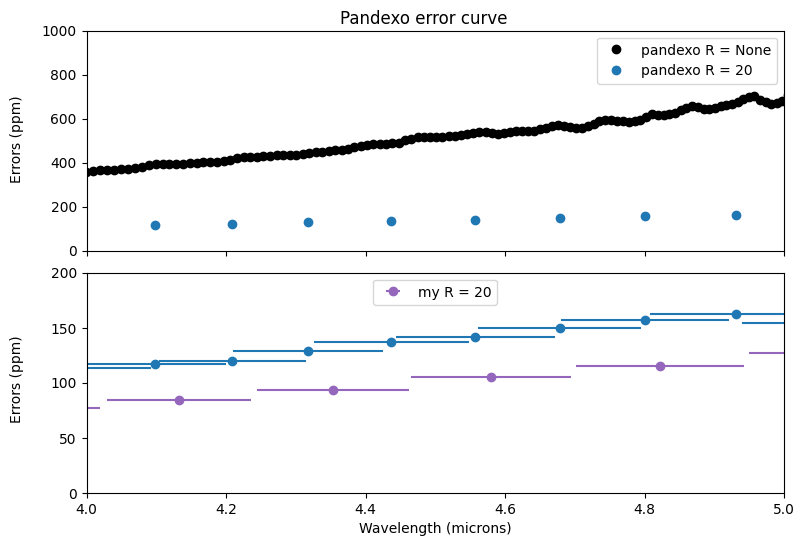

In [7]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)

axs[0].plot(x, e, 'o', c = 'black', label = 'pandexo R = None')
axs[0].plot(x20, e20, 'o', c = 'tab:blue', label = 'pandexo R = 20')
axs[0].set_ylim(0, 1000)
axs[0].legend()

# need to half the bin widths for errobar plotting
axs[1].errorbar(new_wave, new_errs, None, np.array(dellambs)/2, 'o', c = 'tab:purple', label = 'my R = 20')
axs[1].errorbar(x20, e20, None, np.array(pandexo_bin_widths)/2, 'o', c = 'tab:blue')
axs[1].set_xlim(4,5)
axs[1].set_ylim(0, 200)
axs[1].set_xlabel('Wavelength (microns)')
axs[1].legend(loc = 'upper center')

# Labels
fig.suptitle('Pandexo error curve', y = 0.915)
fig.text(0.04, 0.3, 'Errors (ppm)', va='center', rotation='vertical')
fig.text(0.04, 0.7, 'Errors (ppm)', va='center', rotation='vertical')
plt.show()

### checking if the bin spacing increases with wavelength as expected

In [8]:
# calculating pandexo's native resolution bin spacing
pandexo_dellambs = []
for i in range(len(x)):
    if i == 0:
        dellamb = x[i+1] - x[i]
    elif i == len(x) - 1:
        dellamb = x[i] - x[i-1]
    else:
        dellamb = (x[i+1] - x[i-1]) / 2
    pandexo_dellambs.append(dellamb)

In [9]:
# calculating pandexo's R = 20 bin spacing
pandexo_dellambs20 = []
for i in range(len(x20)):
    if i == 0:
        dellamb20 = x20[i+1] - x20[i]
    elif i == len(x20) - 1:
        dellamb20 = x20[i] - x20[i-1]
    else:
        dellamb20 = (x20[i+1] - x20[i-1]) / 2
    pandexo_dellambs20.append(dellamb20)

# slope of best fit line gives R
my_R      = np.polyfit(np.array(dellambs)[:-1], new_wave[:-1], 1)[0]
pandexo_RNone = np.polyfit(pandexo_dellambs, x, 1)[0]
pandexo_R20 = np.polyfit(pandexo_dellambs20, x20, 1)[0]
print(f'My binned errors are at R = {my_R:.2f} (excluding last bin) , but Pandexo is R = {pandexo_RNone:.2f} and {pandexo_R20:.2f}?')

My binned errors are at R = 20.00 (excluding last bin) , but Pandexo is R = -175.03 and 31.70?


In [10]:
print(np.median(x/pandexo_dellambs))
print(np.median(x20/pandexo_dellambs20))
print(np.median(new_wave/np.array(dellambs)))

294.9040034360901
36.6360217495206
20.0


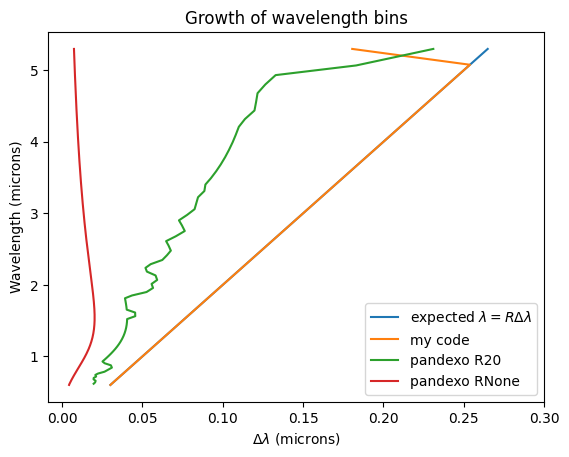

In [11]:
plt.plot(np.array(new_wave) / R, new_wave, label = r'expected $\lambda = R\Delta\lambda$')
plt.plot(np.array(dellambs), new_wave, label = 'my code')
plt.plot(pandexo_dellambs20, x20, label = 'pandexo R20')
plt.plot(pandexo_dellambs, x, label = 'pandexo RNone')

plt.xlim(None , 0.3)

plt.title('Growth of wavelength bins')
plt.ylabel('Wavelength (microns)')
plt.xlabel(r'$\Delta\lambda$ (microns)')

plt.legend(loc = 'lower right')
plt.show()

### trying fixed bin size to see if I get same behavior

In [12]:
print(len(pandexo_dellambs20))
num_bins = len(e) / 5
num_bins

78


80.6

In [13]:
test_errs = []
test_waves = []
bin_sizes = []
for i in range(int(num_bins)):
    center = x[5*i + 2]
    binn = e[5*i:5*(i+1)]
    wave_binn = x[5*i:5*(i+1)]
    bin_size = wave_binn[-1] - wave_binn[0]
    avg = np.sqrt( 1 / (np.sum(binn**float(-2))) )
    
    test_errs.append(avg)
    test_waves.append(center)
    bin_sizes.append(bin_size)

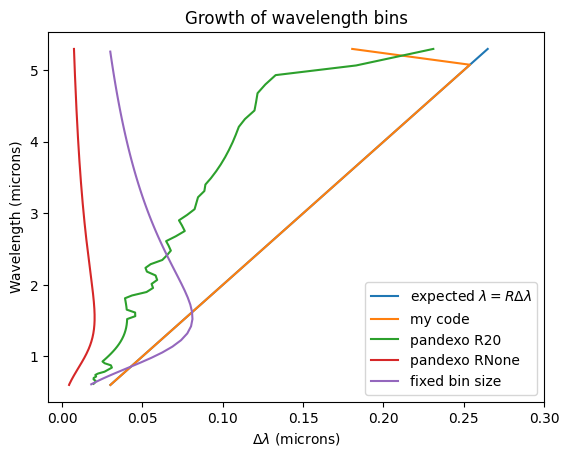

In [14]:
plt.plot(np.array(new_wave) / R, new_wave, label = r'expected $\lambda = R\Delta\lambda$')
plt.plot(np.array(dellambs), new_wave, label = 'my code')
plt.plot(pandexo_dellambs20, x20, label = 'pandexo R20')
plt.plot(pandexo_dellambs, x, label = 'pandexo RNone')
plt.plot(bin_sizes, test_waves, label = 'fixed bin size')

plt.xlim(None , 0.3)

plt.title('Growth of wavelength bins')
plt.ylabel('Wavelength (microns)')
plt.xlabel(r'$\Delta\lambda$ (microns)')

plt.legend(loc = 'lower right')
plt.show()

### trying the white light curve

In [15]:
R = 2
new_errs, new_wave, dellambs = bin_errs(x, e, R)

IndexError: index 403 is out of bounds for axis 0 with size 403

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)

axs[0].plot(x, e, 'o', c = 'black', label = 'pandexo R = None')
axs[0].plot(x20, e20, 'o', c = 'tab:blue', label = 'pandexo R = 20')
axs[0].set_ylim(0, 1000)
axs[0].legend()

# need to half the bin widths for errobar plotting
axs[1].errorbar(new_wave, new_errs, None, np.array(dellambs)/2, 'o', c = 'tab:purple', label = 'my R = 20')
axs[1].plot(x20, e20, 'o', c = 'tab:blue')
#axs[1].set_xlim(0.6,1)
axs[1].set_ylim(0, 200)
axs[1].set_xlabel('Wavelength (microns)')
axs[1].legend(loc = 'upper center')

# Labels
fig.suptitle('Pandexo error curve', y = 0.915)
fig.text(0.04, 0.3, 'Errors (ppm)', va='center', rotation='vertical')
fig.text(0.04, 0.7, 'Errors (ppm)', va='center', rotation='vertical')
plt.show()